# **Dokumentacja końcowa - uzupełnienie**
## **Autorzy:** Mateusz Szczęsny, Małgorzata Kubiak
### **Temat projektu:** Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów

## **Pełna treść zadania:**
Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów z możliwością użycia dowolnej miary niepodobieństwa. Porównanie z nienadzorowaną detekcją anomalii za pomocą algorytmów klasyfikacji jednoklasowej dostępnych w środowisku R lub Python.


## **Wprowadzone zmiany**
*   Dodanie miar odległości do "środka klasy" (Można je wywołać wpisując string odpowiadający ich nazwie)
*   Dodane miara oceny LOF
*   Dodane krzywe PR oceniających pod względem klasy anomalii
*   synchronizacja notatnika z Gitem

# Przyspieszenie obliczeń
Aby przyspieszyc obliczenia zmniejszajac wielkosc zbiorow do 2000 nalezy uruchomic ponizszy fragment kodu i ustawic zmienna Speed na True.

In [1]:
Speed = True

## Uzyte bilbioteki

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import test_functions
from our_knn import KNNAnomalyDetector
from sklearn.preprocessing import StandardScaler
import plotting_functions
from sklearn.model_selection import StratifiedKFold, train_test_split
import numba as nb
from sklearn.metrics import precision_recall_curve, auc, f1_score

from pyod.models.knn import KNN
import sklearn.neighbors
import sklearn.ensemble

#%matplotlib ipympl

%load_ext autoreload
%autoreload 2

# Wczytywanie zbiorów danych 

## Zbiór "Thyroid"

In [3]:
# load thyroid dataset
# labels are 0 1 where 1 is anomaly. Feature 1 is an integer. Other features are continuos
thyroid_data = pd.read_csv('thyroid.csv')

thyroid_data_columns = thyroid_data.columns
thyroid_features = thyroid_data[thyroid_data_columns[:6]]
thyroid_labels = thyroid_data[thyroid_data_columns[6]]

# change labels so 1 in no anomaly and -1 is anomaly (sklearn anomaly detecion convention)
thyroid_labels[thyroid_labels == 1] = -1
thyroid_labels[thyroid_labels == 0] = 1

In [4]:
if Speed:
  # shrink dataset for test purposes
  thyroid_features, _, thyroid_labels, _ = train_test_split(thyroid_features, thyroid_labels, test_size=0.6, random_state=42, stratify=thyroid_labels)

In [5]:
_, [thyroid_anomaly_count, thyroid_normal_count] = np.unique(thyroid_labels, return_counts=True)
thyroid_guess_level_anomaly = thyroid_anomaly_count / (thyroid_anomaly_count + thyroid_normal_count)
thyroid_guess_level_normal = thyroid_normal_count / (thyroid_anomaly_count + thyroid_normal_count)

## Zbiór "Shuttle"

In [6]:
# shuttle dataset loading. The dataset cointains 9 features and 7 classes. Class '1' makes up 80% of the dataset. For ourlier detection class '4'is discarted and the other classes are combined.
shuttle_colnames=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'label']
shuttle_data = pd.read_csv('shuttle.tst', sep=' ', header=None, names=shuttle_colnames)

shuttle_data = shuttle_data[shuttle_data['label'] != 4] # remove class '4'

shuttle_features = shuttle_data[shuttle_colnames[:9]]
shuttle_labels = shuttle_data[shuttle_colnames[9]]

shuttle_labels[shuttle_labels == 1] = 1
shuttle_labels[(shuttle_labels == 2) | (shuttle_labels == 3) | (shuttle_labels == 5) | (shuttle_labels == 6) | (shuttle_labels == 7)] = -1


In [7]:
if Speed:
  # shrink dataset for test purposes
  shuttle_features, _, shuttle_labels, _ = train_test_split(shuttle_features, shuttle_labels, test_size=0.8, random_state=42, stratify=shuttle_labels)

In [8]:
# add standard scaler because of large feature value range differences
shuttle_scaler = StandardScaler()
shuttle_feature_columns = shuttle_features.columns
shuttle_features = pd.DataFrame(shuttle_scaler.fit_transform(shuttle_features), columns=shuttle_feature_columns)

In [9]:
_, [shuttle_anomaly_count, shuttle_normal_count] = np.unique(shuttle_labels, return_counts=True)
shuttle_guess_level_anomaly = shuttle_anomaly_count / (shuttle_anomaly_count + shuttle_normal_count)
shuttle_guess_level_normal = shuttle_normal_count / (shuttle_anomaly_count + shuttle_normal_count)

# Testy dla różnych metryk odległości i liczby sąsiadów

## Zbiór "thyroid"

In [10]:
# test parameters
distances = ["euclidean", "manhattan", "minkowski3"]
n_neighbors = [1, 5, 10, 50, 500]

In [11]:
thyroid_distance_result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, distances, [None])

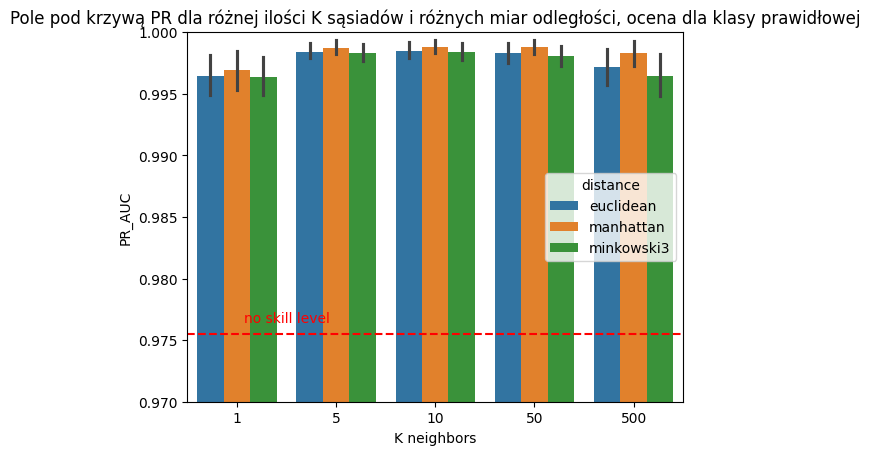

In [12]:
fig, ax = plt.subplots()
sns.barplot(thyroid_distance_result_df, x="K neighbors", y="PR_AUC", hue="distance", ax=ax)
ax.set_ylim(0.97, 1)
ax.axhline(y=thyroid_guess_level_normal, color='red', linestyle='--', label="guess level")
ax.text(x=0.5, y=thyroid_guess_level_normal + 0.001, s='no skill level', color='red', ha='center')
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości, ocena dla klasy prawidłowej")
plt.show()

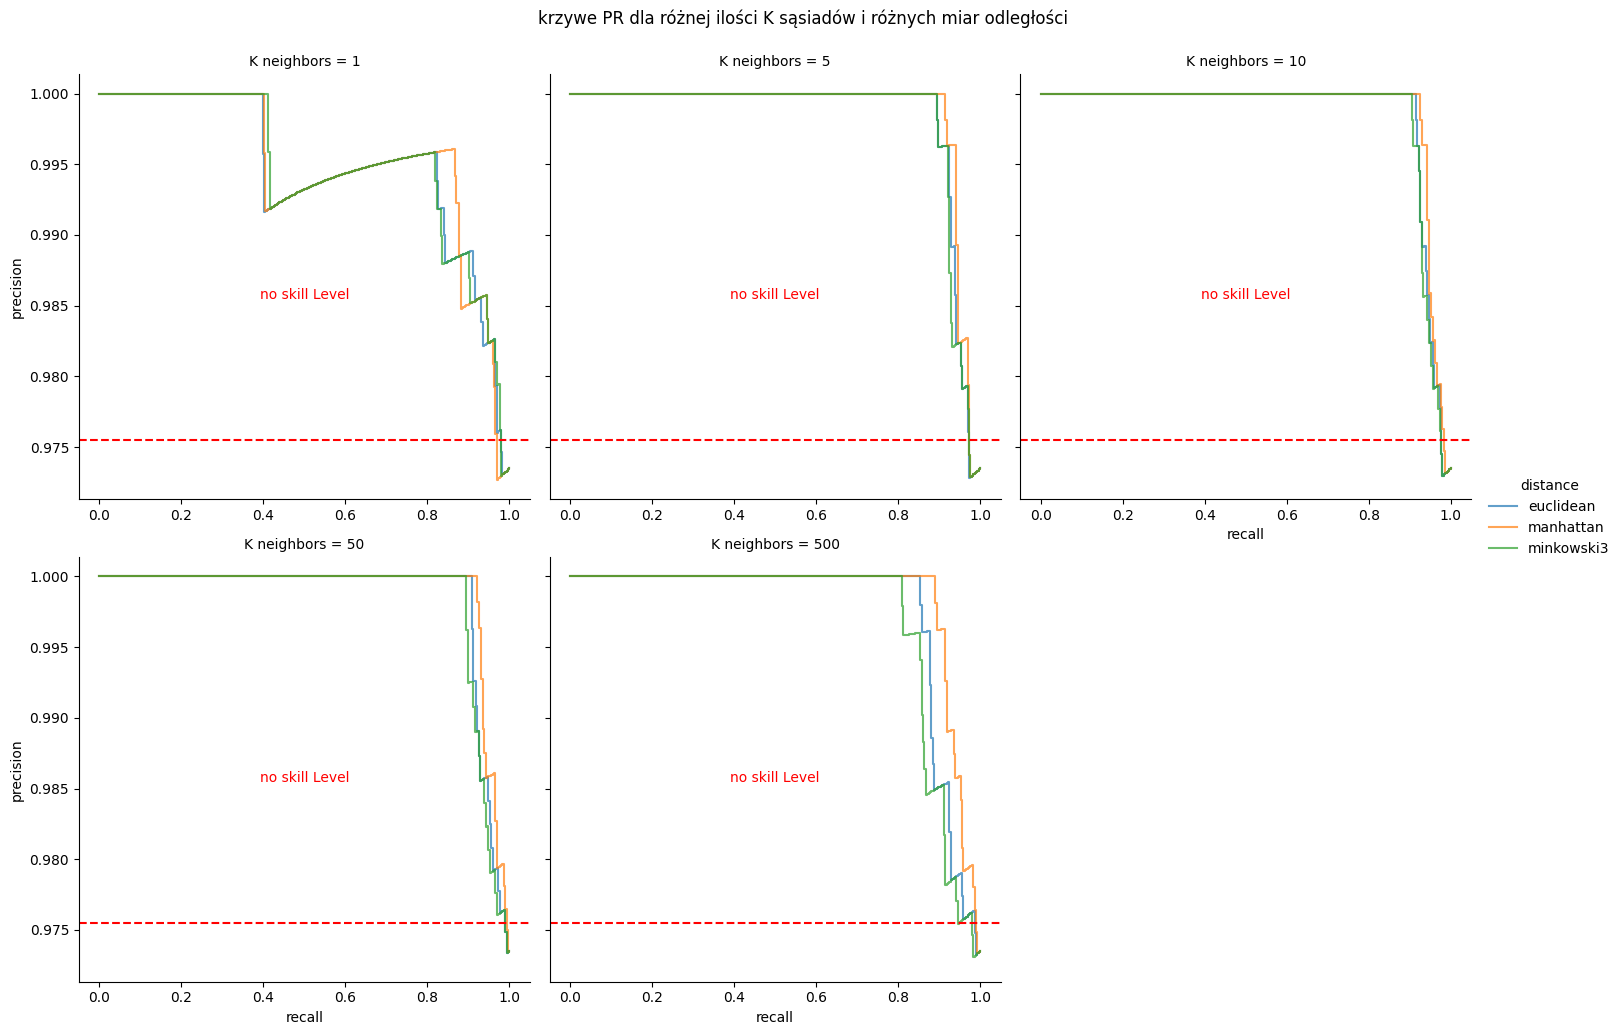

In [13]:
#plot PR curves
pr_df = thyroid_distance_result_df[thyroid_distance_result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

g = sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=3,
    alpha=0.7,
    errorbar=None,
    drawstyle='steps-post'
)

for ax in g.axes.flat:
    ax.axhline(y=thyroid_guess_level_normal, color='red', linestyle='--', label="guess level")
    ax.text(x=0.5, y=thyroid_guess_level_normal + 0.01, s='no skill Level', color='red', ha='center')

g.fig.suptitle("krzywe PR dla różnej ilości K sąsiadów i różnych miar odległości", y=1.03)
plt.show()

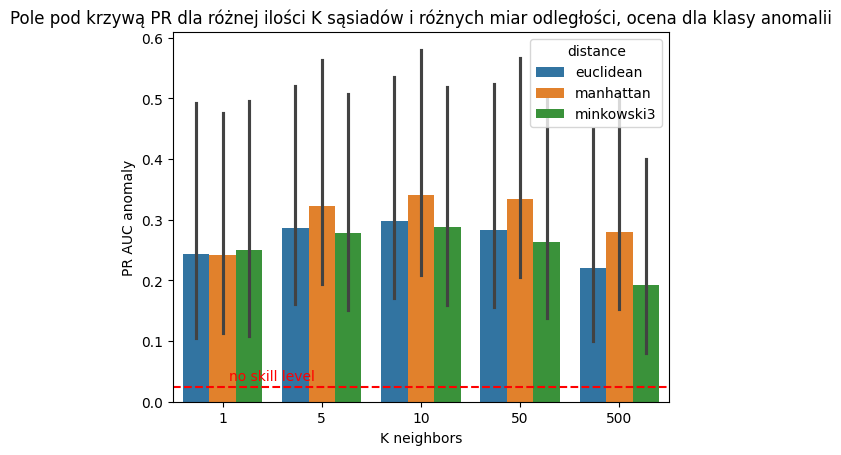

In [14]:
fig, ax = plt.subplots()
sns.barplot(thyroid_distance_result_df, x="K neighbors", y="PR AUC anomaly", hue="distance", ax=ax)
#ax.set_ylim(0.97, 1)
ax.axhline(y=thyroid_guess_level_anomaly, color='red', linestyle='--', label="guess level")
ax.text(x=0.5, y=thyroid_guess_level_anomaly + 0.01, s='no skill level', color='red', ha='center')
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości, ocena dla klasy anomalii")
plt.show()

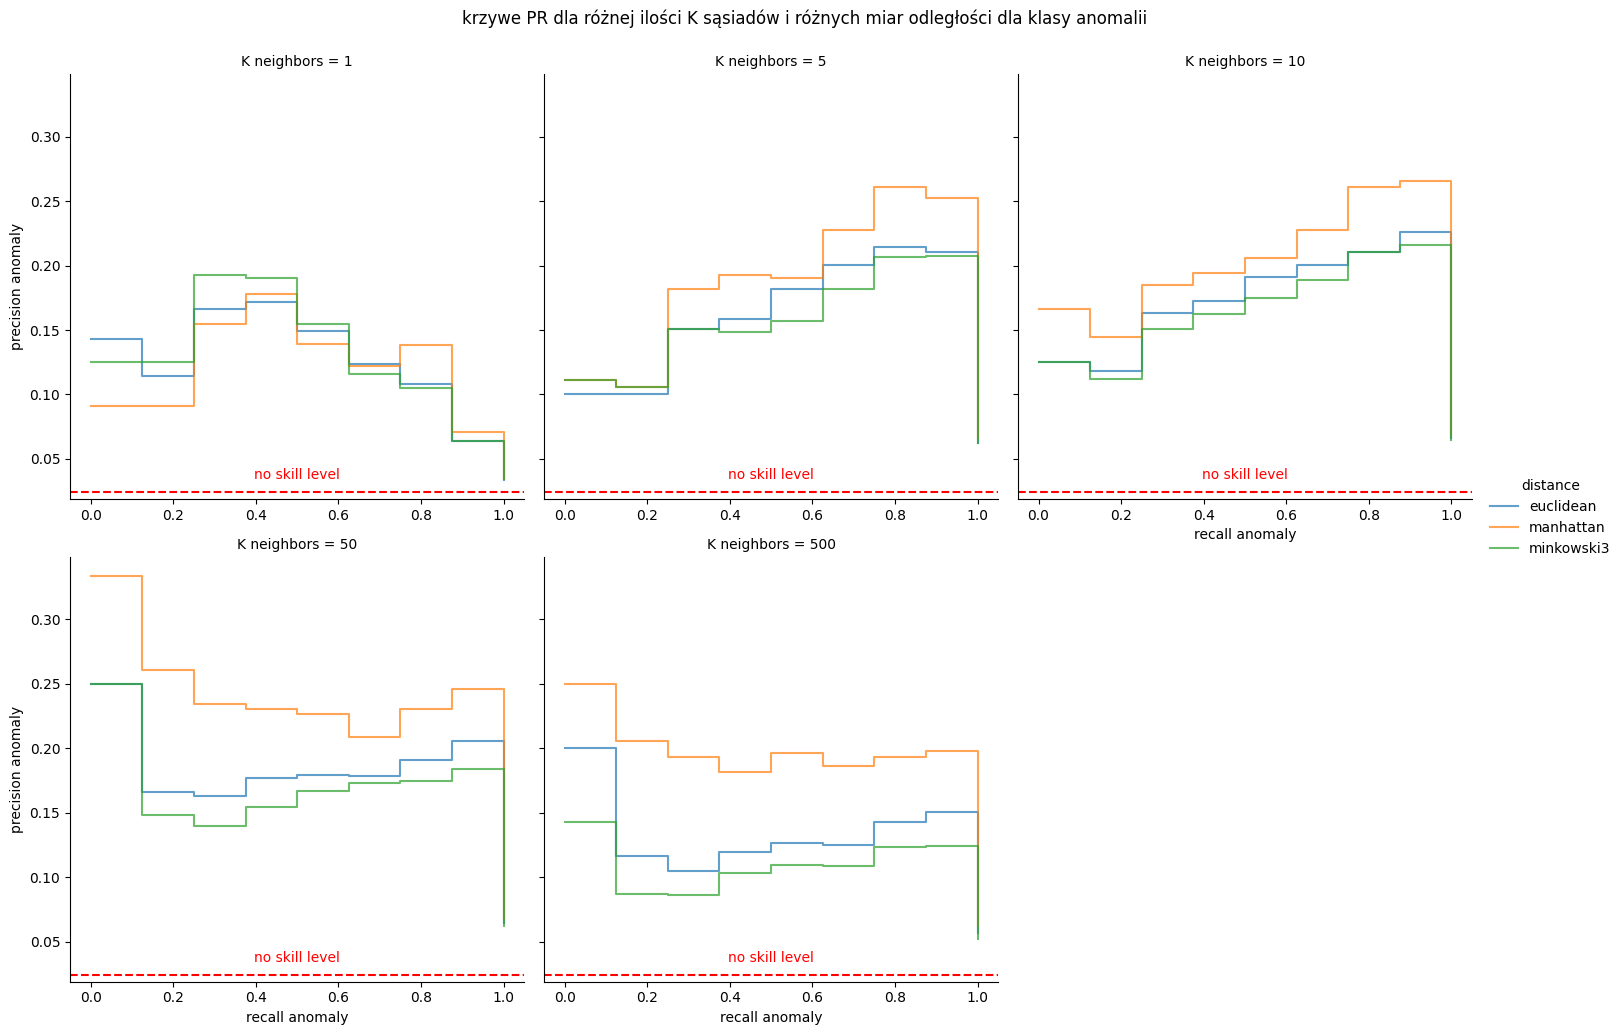

In [15]:
#plot PR curves
pr_df = thyroid_distance_result_df[thyroid_distance_result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall anomaly', 'precision anomaly'])

g = sns.relplot(
    data=pr_df,
    x="recall anomaly", y="precision anomaly",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=3,
    alpha=0.7,
    errorbar=None,
    drawstyle='steps-post'
)

for ax in g.axes.flat:
    ax.axhline(y=thyroid_guess_level_anomaly, color='red', linestyle='--', label="guess level")
    ax.text(x=0.5, y=thyroid_guess_level_anomaly + 0.01, s='no skill level', color='red', ha='center')

g.fig.suptitle("krzywe PR dla różnej ilości K sąsiadów i różnych miar odległości dla klasy anomalii", y=1.03)
plt.show()

Powyżej został przedstawiony nowe wykresy czyli krzywe PR obliczone dla klasy anomalii. Wyniki są znacznie mniejsze ale dalej znacznie wyższe od klasyfikacji losowej czyli w tym wypadku takiej która zawsze zgaduje że przykład nie jest anomalią. Na wykresach słupkowych widać też że odchylenie standardowe pola pod wykresem PR (zaznaczone jako czarne passki) jest znaczne. 

## Zbiór "shuttle"

In [16]:
shuttle_distance_result_df = test_functions.test_loop(shuttle_features, shuttle_labels, n_neighbors, distances, [None])

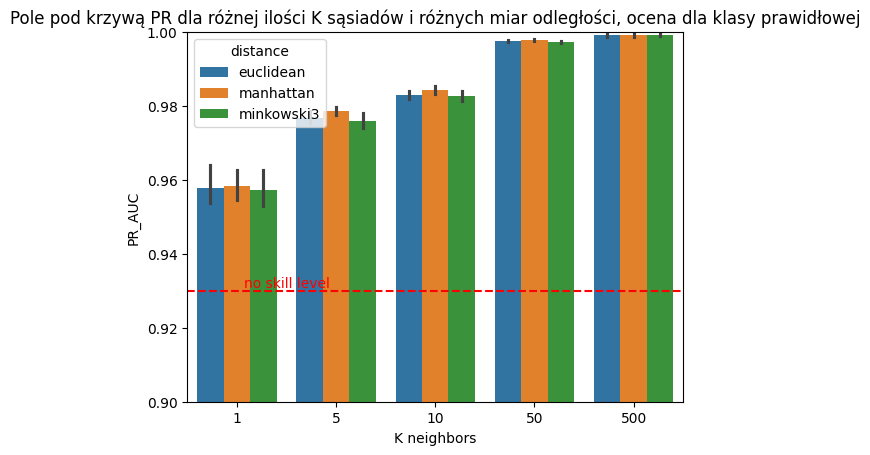

In [17]:
fig, ax = plt.subplots()
sns.barplot(shuttle_distance_result_df, x="K neighbors", y="PR_AUC", hue="distance", ax=ax)
ax.set_ylim(0.9, 1)
ax.axhline(y=shuttle_guess_level_normal, color='red', linestyle='--', label="guess level")
ax.text(x=0.5, y=shuttle_guess_level_normal + 0.001, s='no skill level', color='red', ha='center')
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości, ocena dla klasy prawidłowej")
plt.show()

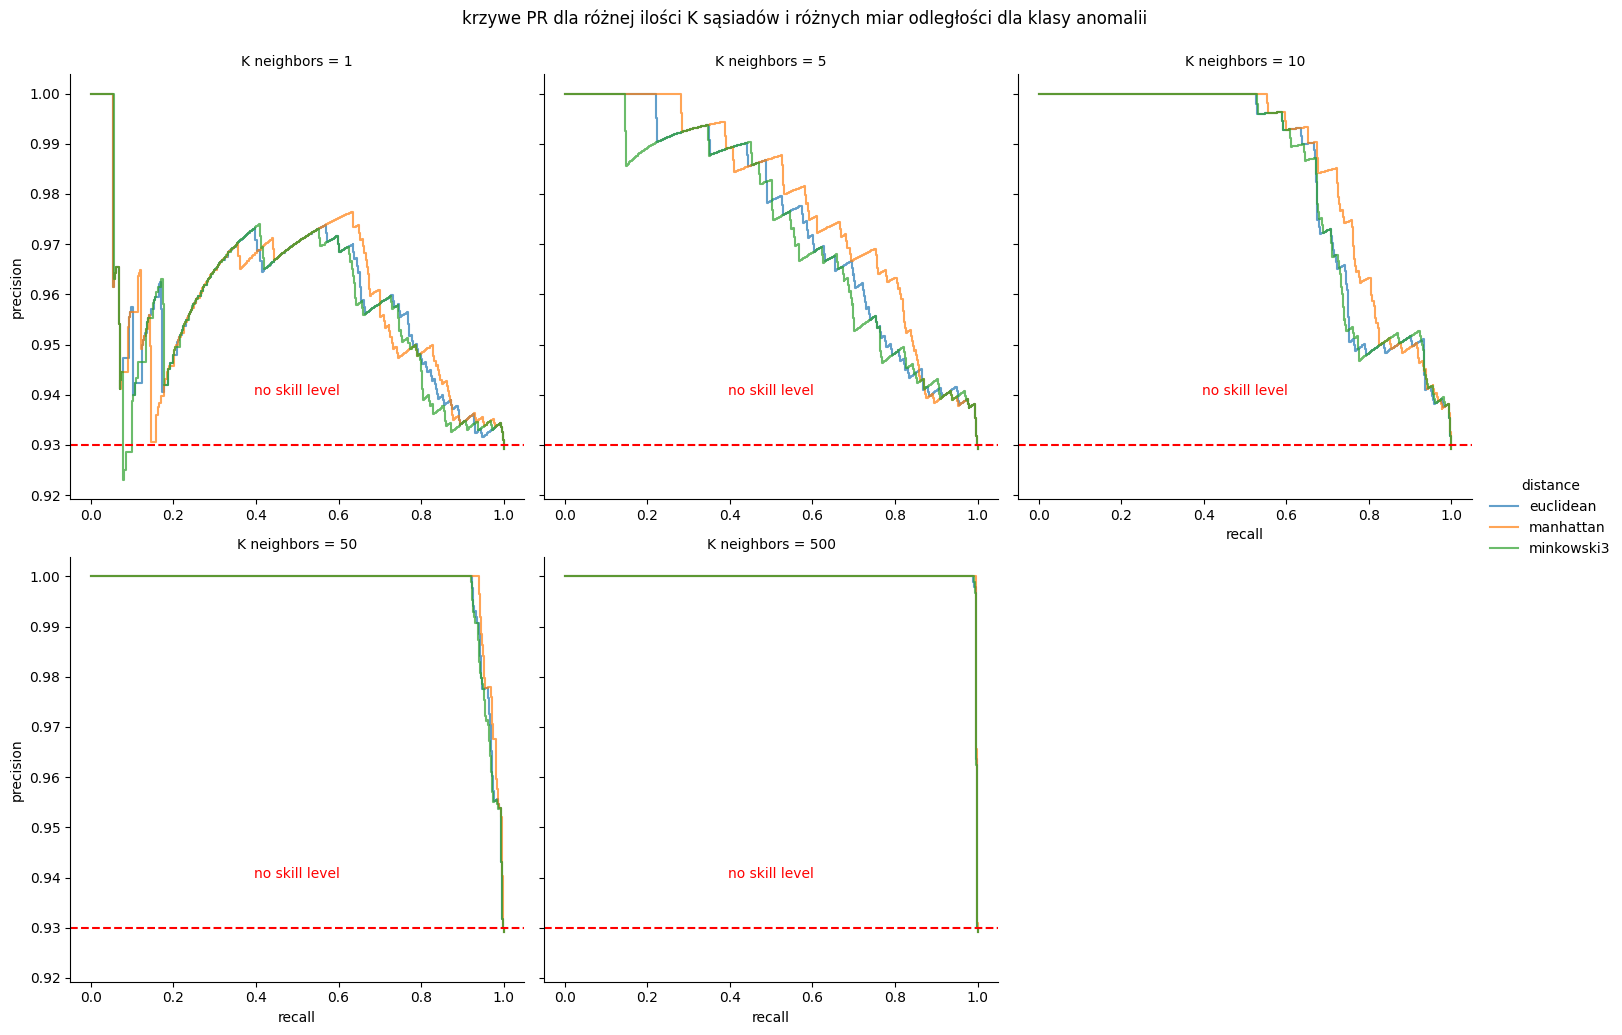

In [18]:
#plot PR curves
pr_df = shuttle_distance_result_df[shuttle_distance_result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

g = sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=3,
    alpha=0.7,
    errorbar=None,
    drawstyle='steps-post'
)

for ax in g.axes.flat:
    ax.axhline(y=shuttle_guess_level_normal, color='red', linestyle='--', label="guess level")
    ax.text(x=0.5, y=shuttle_guess_level_normal + 0.01, s='no skill level', color='red', ha='center')

g.fig.suptitle("krzywe PR dla różnej ilości K sąsiadów i różnych miar odległości dla klasy anomalii", y=1.03)
plt.show()

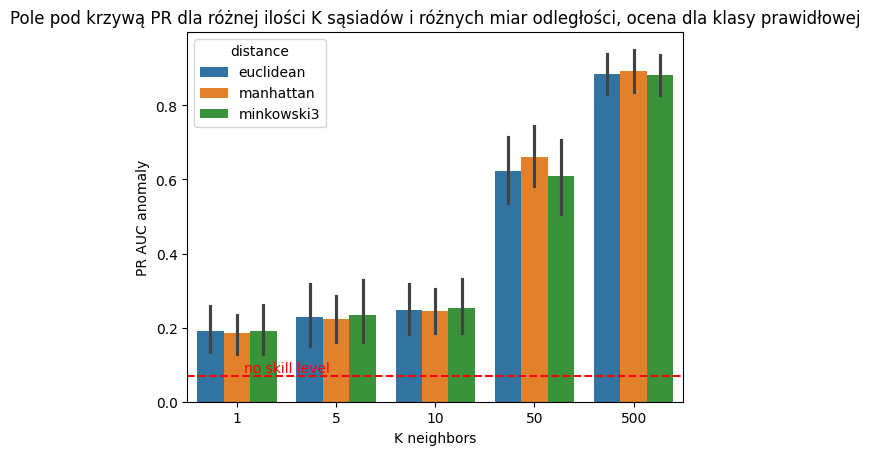

In [19]:
fig, ax = plt.subplots()
sns.barplot(shuttle_distance_result_df, x="K neighbors", y="PR AUC anomaly", hue="distance", ax=ax)
#ax.set_ylim(0.9, 1)
ax.axhline(y=shuttle_guess_level_anomaly, color='red', linestyle='--', label="guess level")
ax.text(x=0.5, y=shuttle_guess_level_anomaly + 0.01, s='no skill level', color='red', ha='center')
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości, ocena dla klasy prawidłowej")
plt.show()

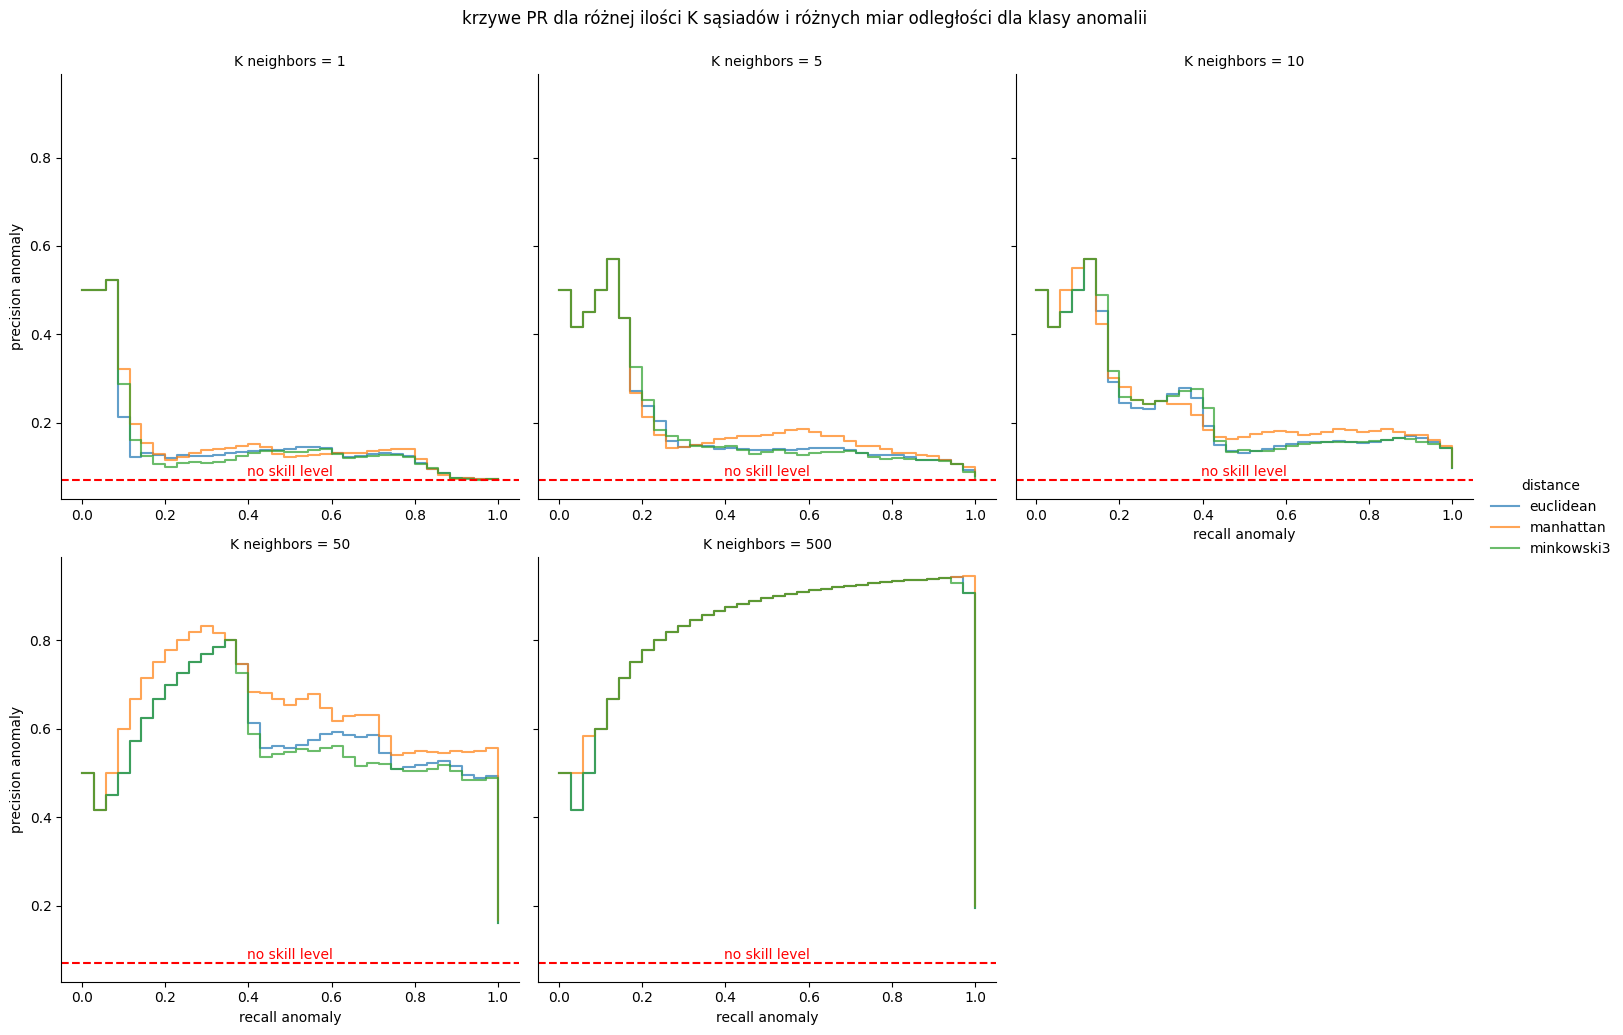

In [20]:
#plot PR curves
pr_df = shuttle_distance_result_df[shuttle_distance_result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall anomaly', 'precision anomaly'])

g = sns.relplot(
    data=pr_df,
    x="recall anomaly", y="precision anomaly",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=3,
    alpha=0.7,
    errorbar=None,
    drawstyle='steps-post'
)

for ax in g.axes.flat:
    ax.axhline(y=shuttle_guess_level_anomaly, color='red', linestyle='--', label="guess level")
    ax.text(x=0.5, y=shuttle_guess_level_anomaly + 0.01, s='no skill level', color='red', ha='center')

g.fig.suptitle("krzywe PR dla różnej ilości K sąsiadów i różnych miar odległości dla klasy anomalii", y=1.03)
plt.show()

## Test LOF

In [23]:
# test parameters
score_funcs = ["avgNNearest", "distFromNth", "averageDist", "LOF"]
n_neighbors = [5, 10, 50]

In [27]:
thyroid_score_result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, [None], score_funcs)

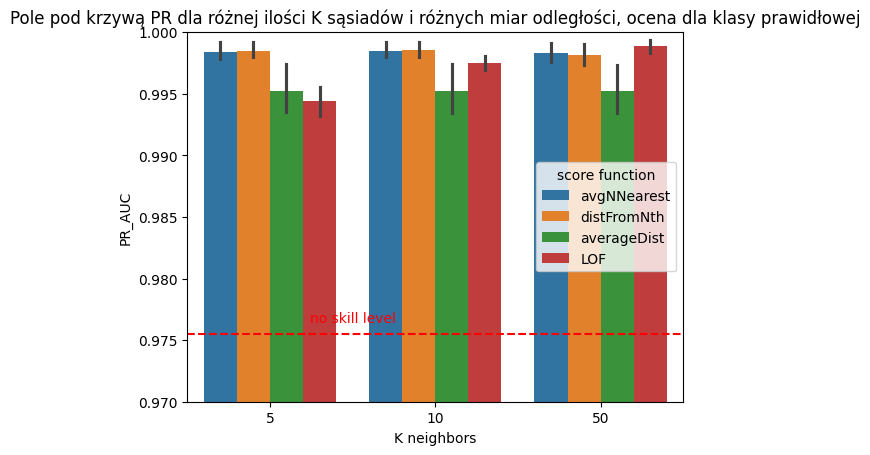

In [30]:
fig, ax = plt.subplots()
sns.barplot(thyroid_score_result_df, x="K neighbors", y="PR_AUC", hue="score function", ax=ax)
ax.set_ylim(0.97, 1)
ax.axhline(y=thyroid_guess_level_normal, color='red', linestyle='--', label="guess level")
ax.text(x=0.5, y=thyroid_guess_level_normal + 0.001, s='no skill level', color='red', ha='center')
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości, ocena dla klasy prawidłowej")
plt.show()

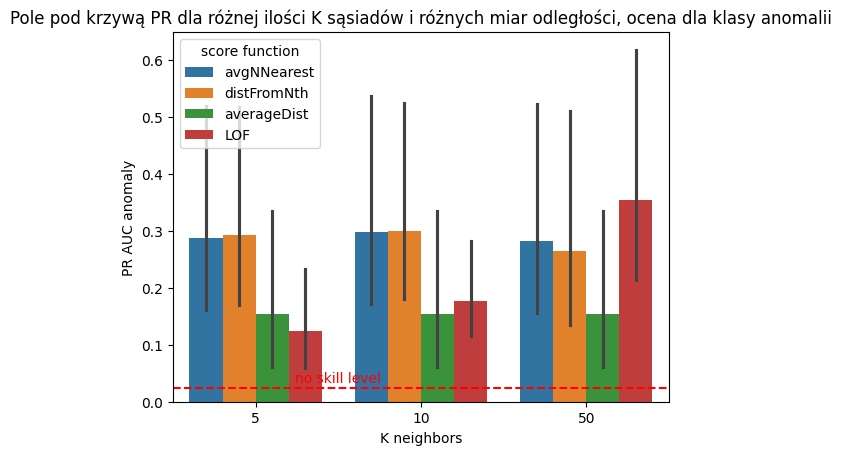

In [31]:
fig, ax = plt.subplots()
sns.barplot(thyroid_score_result_df, x="K neighbors", y="PR AUC anomaly", hue="score function", ax=ax)
#ax.set_ylim(0.97, 1)
ax.axhline(y=thyroid_guess_level_anomaly, color='red', linestyle='--', label="guess level")
ax.text(x=0.5, y=thyroid_guess_level_anomaly + 0.01, s='no skill level', color='red', ha='center')
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości, ocena dla klasy anomalii")
plt.show()

LOF daje slabe wyniki dla małej liczby sąsiadów ale dobre dla dużej co jest spodziewane biorąc pod uwagę zasadę działania algorytmu